In [ ]:
!apt-get update
!apt-get install -y sox libsox-dev libsox-fmt-all
!pip install --upgrade pip
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install seaborn matplotlib opencv-python kaggle


Hit:1 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:5 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Reading package lists... Done
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading

In [ ]:
!unzip -o /content/road-sign-detection.zip -d /content/data/
!ls /content/data/


Archive:  /content/road-sign-detection.zip
  inflating: /content/data/annotations/road0.xml  
  inflating: /content/data/annotations/road1.xml  
  inflating: /content/data/annotations/road10.xml  
  inflating: /content/data/annotations/road100.xml  
  inflating: /content/data/annotations/road101.xml  
  inflating: /content/data/annotations/road102.xml  
  inflating: /content/data/annotations/road103.xml  
  inflating: /content/data/annotations/road104.xml  
  inflating: /content/data/annotations/road105.xml  
  inflating: /content/data/annotations/road106.xml  
  inflating: /content/data/annotations/road107.xml  
  inflating: /content/data/annotations/road108.xml  
  inflating: /content/data/annotations/road109.xml  
  inflating: /content/data/annotations/road11.xml  
  inflating: /content/data/annotations/road110.xml  
  inflating: /content/data/annotations/road111.xml  
  inflating: /content/data/annotations/road112.xml  
  inflating: /content/data/annotations/road113.xml  
  inflati

Total images: 877
Total annotations: 877


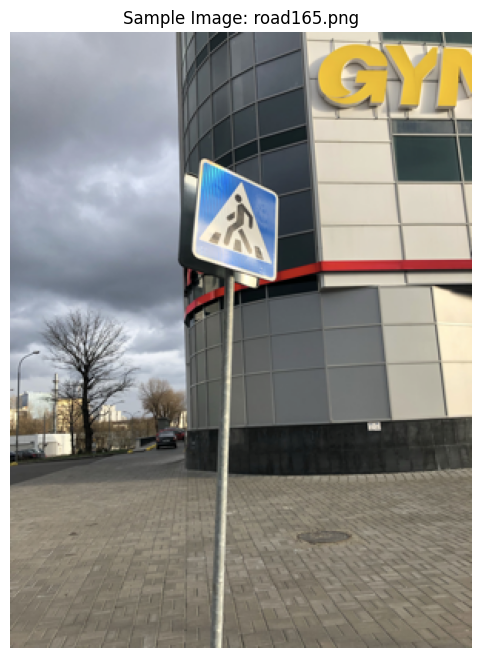

In [ ]:
import matplotlib.pyplot as plt
import cv2
import os
import random

images_dir = '/Users/ananth/VisionX/Traffic_Sign_Detection/Data/Images'
annotations_dir = '/Users/ananth/VisionX/Traffic_Sign_Detection/Data/Annotations'
image_files = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
annotation_files = [f for f in os.listdir(annotations_dir) if f.endswith('.xml')]
print(f"Total images: {len(image_files)}")
print(f"Total annotations: {len(annotation_files)}")
sample_image = random.choice(image_files)
img_path = os.path.join(images_dir, sample_image)
img = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(8,8))
plt.imshow(img_rgb)
plt.title(f"Sample Image: {sample_image}")
plt.axis('off')
plt.show()


In [ ]:
import xml.etree.ElementTree as ET

def convert_box(size, box):
    dw, dh = 1. / size[0], 1. / size[1]
    x_center = (box[0] + box[1]) / 2.0 - 1
    y_center = (box[2] + box[3]) / 2.0 - 1
    width = box[1] - box[0]
    height = box[3] - box[2]
    return x_center * dw, y_center * dh, width * dw, height * dh

def convert_voc_to_yolo():
    annotations_dir = '/content/data/annotations'
    labels_dir = '/content/data/labels'
    os.makedirs(labels_dir, exist_ok=True)
    class_names = ['trafficlight', 'speedlimit', 'crosswalk', 'stop']
    for anno in os.listdir(annotations_dir):
        if not anno.endswith('.xml'):
            continue
        file_name = anno.split('.')[0]
        xml_path = os.path.join(annotations_dir, anno)
        txt_path = os.path.join(labels_dir, f"{file_name}.txt")
        tree = ET.parse(xml_path)
        root = tree.getroot()
        size = root.find('size')
        w = int(size.find('width').text)
        h = int(size.find('height').text)
        with open(txt_path, 'w') as out_file:
            for obj in root.iter('object'):
                cls = obj.find('name').text
                if cls not in class_names:
                    continue
                if int(obj.find('difficult').text) == 1:
                    continue
                xmlbox = obj.find('bndbox')
                bbox = [float(xmlbox.find(x).text) for x in ('xmin', 'xmax', 'ymin', 'ymax')]
                yolo_bbox = convert_box((w, h), bbox)
                cls_id = class_names.index(cls)
                out_file.write(f"{cls_id} " + " ".join([f"{coord:.6f}" for coord in yolo_bbox]) + '\n')
    print("Conversion from Pascal VOC to YOLO format completed.")

convert_voc_to_yolo()


Conversion from Pascal VOC to YOLO format completed.


In [ ]:
from sklearn.model_selection import train_test_split
import shutil
import random
import os

images_dir = '/content/data/images'
labels_dir = '/content/data/labels'
all_images = [f for f in os.listdir(images_dir) if f.endswith(('.jpg', '.jpeg', '.png'))]
all_images = [f for f in all_images if os.path.exists(os.path.join(labels_dir, f"{os.path.splitext(f)[0]}.txt"))]
random.shuffle(all_images)
train_images, val_images = train_test_split(all_images, test_size=0.2, random_state=42)
print(f"Total images: {len(all_images)}")
print(f"Training images: {len(train_images)}")
print(f"Validation images: {len(val_images)}")


Total images: 877
Training images: 701
Validation images: 176


In [ ]:
train_images_dir = '/content/yolov5/data/train/images'
train_labels_dir = '/content/yolov5/data/train/labels'
val_images_dir = '/content/yolov5/data/val/images'
val_labels_dir = '/content/yolov5/data/val/labels'
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(train_labels_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

def copy_data(image_list, destination_images_dir, destination_labels_dir):
    for img in image_list:
        src_img_path = os.path.join(images_dir, img)
        dst_img_path = os.path.join(destination_images_dir, img)
        shutil.copyfile(src_img_path, dst_img_path)
        src_label_path = os.path.join(labels_dir, f"{os.path.splitext(img)[0]}.txt")
        dst_label_path = os.path.join(destination_labels_dir, f"{os.path.splitext(img)[0]}.txt")
        shutil.copyfile(src_label_path, dst_label_path)

copy_data(train_images, train_images_dir, train_labels_dir)
copy_data(val_images, val_images_dir, val_labels_dir)
print("Dataset organized into training and validation sets.")


Dataset organized into training and validation sets.


In [ ]:
!ls /content/yolov5/data/train/images/ | head -n 5
!ls /content/yolov5/data/val/labels/ | head -n 5


road0.png
road100.png
road101.png
road102.png
road103.png
road0.txt
road100.txt
road101.txt
road102.txt
road105.txt


In [ ]:
import os

yolov5_dir = '/content/yolov5'
if os.path.exists(yolov5_dir):
    print("YOLOv5 repository already exists. Pulling the latest changes...")
    %cd yolov5
    !git pull
else:
    print("Cloning YOLOv5 repository...")
    %cd /content/
    !git clone https://github.com/ultralytics/yolov5.git
    %cd yolov5


YOLOv5 repository already exists. Pulling the latest changes...
[Errno 2] No such file or directory: 'yolov5'
/content/yolov5
fatal: not a git repository (or any of the parent directories): .git


In [ ]:
!pip install -r requirements.txt


In [ ]:
import yaml

custom_yaml = {
    'train': 'data/train/images',
    'val': 'data/val/images',
    'nc': 4,
    'names': ['trafficlight', 'speedlimit', 'crosswalk', 'stop']
}

with open('customVOC.yaml', 'w') as file:
    yaml.dump(custom_yaml, file)

print("customVOC.yaml created successfully.")


In [ ]:
with open('customVOC.yaml', 'r') as file:
    print(file.read())


In [ ]:
!python train.py --img 320 --batch 16 --epochs 100 --data customVOC.yaml --weights yolov5s.pt --workers 2 --cache


In [ ]:
import torch

model = torch.hub.load('ultralytics/yolov5', 'custom', path='runs/train/exp/weights/best.pt', force_reload=True)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
print("Trained YOLOv5 model loaded successfully.")


In [ ]:
import cv2
import matplotlib.pyplot as plt
import random
import os

val_images_dir = '/content/yolov5/data/val/images'
val_images = os.listdir(val_images_dir)
sample_images = random.sample(val_images, 8)
fig, axes = plt.subplots(2, 4, figsize=(20,10))
for idx, img_name in enumerate(sample_images):
    img_path = os.path.join(val_images_dir, img_name)
    img = cv2.imread(img_path)
    results = model(img)
    result_img = results.render()[0]
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    row = idx // 4
    col = idx % 4
    axes[row, col].imshow(result_img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Image: {img_name}")
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import files
import shutil

uploaded = files.upload()
custom_dir = '/content/yolov5/custom_images'
os.makedirs(custom_dir, exist_ok=True)
for filename in uploaded.keys():
    shutil.move(filename, os.path.join(custom_dir, filename))
print(f"Uploaded {len(uploaded)} images to {custom_dir}.")


In [ ]:
custom_images = os.listdir(custom_dir)
num_images = len(custom_images)
cols = 4
rows = num_images // cols + int(num_images % cols > 0)
fig, axes = plt.subplots(rows, cols, figsize=(20, 5 * rows))
for idx, img_name in enumerate(custom_images):
    img_path = os.path.join(custom_dir, img_name)
    img = cv2.imread(img_path)
    results = model(img)
    result_img = results.render()[0]
    result_img = cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB)
    row = idx // cols
    col = idx % cols
    axes[row, col].imshow(result_img)
    axes[row, col].axis('off')
    axes[row, col].set_title(f"Image: {img_name}")
for i in range(idx + 1, rows * cols):
    row = i // cols
    col = i % cols
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')